In [1]:
import tensorflow as tf
import numpy as np
from keras import layers, optimizers
from keras.models import Sequential
import os
from wandb.keras import WandbCallback
from keras.callbacks import  EarlyStopping

In [2]:
import wandb
wandb.init(project="deepfake", entity="dat550")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dat550 (use `wandb login --relogin` to force relogin)


In [3]:
# constants
img_height = 128
img_width = 128
data_dir = "./data/processed/"

## preprocess data

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  #batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  #batch_size=batch_size
   )

Found 2050 files belonging to 2 classes.
Using 1640 files for training.
Found 2050 files belonging to 2 classes.
Using 410 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['FAKE', 'REAL']


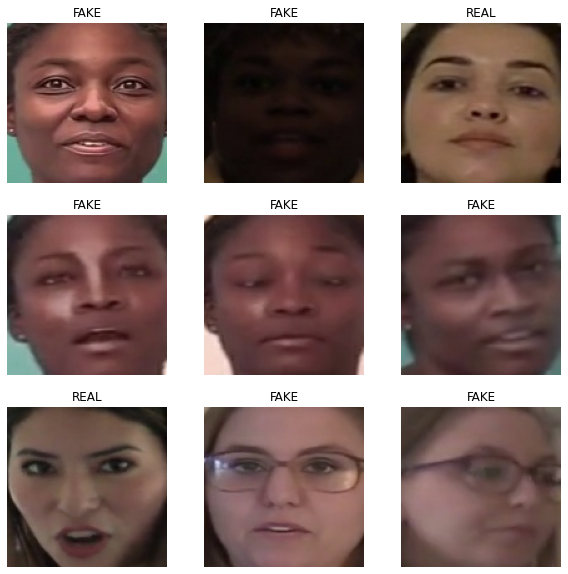

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9843138


In [9]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Weights and Biases Sweep

In [10]:
def train():
   # Default values for hyper-parameters we're going to sweep over
   config_defaults = {
         'epochs': 5,
         'batch_size': 128,
      #   'weight_decay': 0.0005,
         'learning_rate': 1e-3,
         'activation': 'relu',
         'optimizer': 'nadam',
         'hidden_layer_size': 64,
         'conv_layer_1_size': 16,
         'conv_layer_2_size': 32,
         'conv_layer_3_size': 64,
         'dropout': 0.5,
         'momentum': 0.9,
         'seed': 42,
         "use_augmentation": True,
      }
   # Initialize wandb with a sample project name
   wandb.init(config=config_defaults, project="deepfake", entity="dat550")

   # # Config is a variable that holds and saves hyperparameters and inputs
   config = wandb.config

   input_layers = [
       data_augmentation if config.use_augmentation else None,
       layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
       layers.Conv2D(filters = config.conv_layer_1_size, kernel_size=(3, 3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       layers.Conv2D(filters = config.conv_layer_2_size, kernel_size=(3, 3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       layers.Conv2D(filters = config.conv_layer_3_size, kernel_size=(3, 3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       layers.Dropout(config.dropout) if config.dropout > 0 else None,
       layers.Flatten(),
       layers.Dense(wandb.config.hidden_layer_size, activation=config.activation),
       layers.Dense(num_classes)
   ]
   input_layers = [e for e in input_layers if e is not None]

   # create model
   model = Sequential(layers=input_layers)

   # Define the optimizer
   if config.optimizer=='sgd':
      optimizer = tf.keras.optimizers.SGD(lr=config.learning_rate) #, decay=1e-5, momentum=config.momentum, nesterov=True)
   elif config.optimizer=='rmsprop':
      optimizer = tf.keras.optimizers.RMSprop(lr=config.learning_rate,) # decay=1e-5)
   elif config.optimizer=='adam':
      optimizer = tf.keras.optimizers.Adam(lr=config.learning_rate,) # beta_1=0.9, beta_2=0.999, clipnorm=1.0)
   elif config.optimizer=='nadam':
      optimizer = tf.keras.optimizers.Nadam(lr=config.learning_rate,) # beta_1=0.9, beta_2=0.999, clipnorm=1.0)
   
   # Compile the model
   model.compile(optimizer=optimizer,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

   # Train the model
   model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=config.epochs,
      batch_size=config.batch_size,
      callbacks=[WandbCallback(data_type="image", validation_data=val_ds,labels=labels),
               #EarlyStopping(patience=10, restore_best_weights=True)
               ])

In [11]:
#### Slimmer sweep configuration
# sweep training
# Select the hyperparameters you want to tune. This is specified like the following:
# inspired from https://notebook.community/lukas/ml-class/examples/keras-fashion/sweeps
sweep_config = {
    "name": "deepfake-sweep",
   'method': 'grid',
    "metric": {
            "name": "accuracy",
            "goal": "maximize"
        },
    "early_terminate": {
       "type": "hyperband",
       "min_iter": 3
   },
   'parameters': {
        'epochs': {
            'values': [15, 30] # TODO: add more
        },
        'batch_size': {
            'values': [16, 32, 64, 128] # 64, 
        },
        'dropout': {
            'values': [0.0, 0.2, 0.4]
        },
        'conv_layer_1_size': {
            'values': [16,32], #32
        },
        'conv_layer_2_size': {
            'values': [32,64] #64
        },
        'conv_layer_3_size': {
            'values': [64 ,128] # 128
        },
        'hidden_layer_size': {
            'values': [64, 128, 256] # 256
        },
      'learning_rate': { #1e-2,
            'values': [ 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'elu', 'selu', 'softmax']
        },
        "use_augmentation": {
            "values": [False, True] #True, 
        }
   }
}
sweep_id = wandb.sweep(sweep_config, project="deepfake", entity="dat550")

wandb.agent(sweep_id, function=train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: lhd6u0j3
Sweep URL: https://wandb.ai/dat550/deepfake/sweeps/lhd6u0j3


wandb: Agent Starting Run: su682emw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	conv_layer_1_size: 16
wandb: 	conv_layer_2_size: 32
wandb: 	conv_layer_3_size: 64
wandb: 	dropout: 0
wandb: 	epochs: 15
wandb: 	hidden_layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	use_augmentation: False
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


In [ ]:
# sweep training
# Select the hyperparameters you want to tune. This is specified like the following:
# inspired from https://notebook.community/lukas/ml-class/examples/keras-fashion/sweeps
sweep_config = {
    "name": "deepfake-sweep",
   'method': 'grid',
#    "early_terminate": {
#        "type": "hyperband",
#        "min_iter": 3
#    },
    "metric": {
            "name": "accuracy",
            "goal": "maximize"
        },
   'parameters': {
        'epochs': {
            'values': [10, 20] # TODO: add more
        },
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.0, 0.3, 0.4, 0.5]
        },
        'conv_layer_size': {
            'values': [16, 32, 64]
        },
        # 'weight_decay': {
        #     'values': [0.0005, 0.005, 0.05]
        # },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'elu', 'selu', 'softmax']
        },
        "use_augmentation": {
            "values": [True, False]
        }
   }
}
sweep_id = wandb.sweep(sweep_config, project="deepfake", entity="dat550")

wandb.agent(sweep_id, function=train)